# Quantifying Gerrymandering

## Existing Methods

The two main attempts to quantify gerrymandering so far have been:

### 1) The Efficiency Gap

The efficiency gap measures the *wasted vote* of each of party.

The wasted vote is the number of votes that did not go towards the winning candidate. This means votes for the losing candidate, and votes casted for the winning candidate after they had already gotten a majority.

The efficiency gap takes the difference between the number of wasted votes for each party, and divides that by the number of votes casted in total.

It is not a reliable method of measuring gerrymandering as it often falsely identifies or completely misses gerrymandering.

In 2014, roughly the same number of people voted for Democrats and Republicans in Illinois, but Democrats ended up winning 71-47 in the state house, even though the efficiency gap was only 2.3%.

### 2) Supercomputing

Researchers from the University of Illinois have used a supercomputer to generate billions of unbiased maps, and compared them to current districts to see if they were similar. Their method is unique and effective, but computationally expensive.

## Our Method

Our method of measuring gerrymandering begins at its root. Gerrymandering is cracking and packing political communities, so why not find those communities? Our algorithm to do so is an implementation of the iterative method, with constraints of partisanship diversity (grouping like-minded people), compactness, and population.

We then take these communities and compare them to the current districts. The gerrymandering score for a district is the percentage of the district that is not occupied by the community that occupies the largest area in that district.

Let's assume we've already generated the base communities and they are stored in `data/nh_base_communities.pickle`.
Here's what the data looks like:

In [13]:
import pickle

from hacking_the_election.utils.community import Community
from hacking_the_election.serialization.save_precincts import Precinct


with open("data/nh_base_communities.pickle", "rb") as f:
    community_stages, changed_precincts = pickle.load(f)

# Sort the communities in each stage by id.
for stage in community_stages:
    stage.sort(key=lambda c: c.id)

# Update each of the relevant attributes of each of the community objects.
for stage in community_stages:
    for community in stage:
        community.update_partisanship()
        community.update_standard_deviation()
        community.update_compactness()
        community.update_population()

# Print the data.
for i in range(len(community_stages[0])):
    print(f"Community {community_stages[0][i].id}")
    print("Iteration\tPartisanship\tDiversity\tCompactness\tPopulation")
    for s, stage in enumerate(community_stages):
        print("\t\t".join([] \
            + [str(round(i, 3)) for i in [
                s + 1,
                stage[i].partisanship,
                stage[i].standard_deviation,
                stage[i].compactness,
                stage[i].population]]))
    print()

Community 1
Iteration	Partisanship	Diversity	Compactness	Population
1		0.449		10.543		0.438		301672
2		0.451		10.226		0.408		433037
3		0.451		10.482		0.339		433578
4		0.426		10.27		0.356		472926
5		0.426		10.264		0.368		473968

Community 2
Iteration	Partisanship	Diversity	Compactness	Population
1		0.487		10.308		0.303		714549.0
2		0.495		10.19		0.225		583184.0
3		0.494		9.793		0.225		582643.0
4		0.516		8.121		0.302		543295.0
5		0.516		8.155		0.312		542253.0



Here is how each of the constraints changed over the iterations:

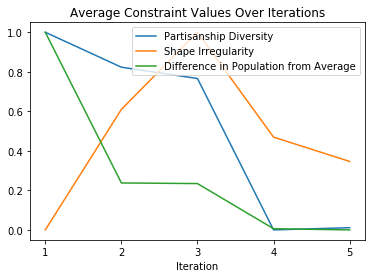

In [14]:
%matplotlib inline


import matplotlib.pyplot as plt


def get_squishing_function(min_val, max_val):
    """
    Returns a function that takes an input between `min_val` and `max_val` and
    returns a proportionate value between 0 and 1.
    """
    def squish(x):
        return (x - min_val) / (max_val - min_val)
    return squish


# Constraint values for each iteration:
average_pop = sum([c.population for c in community_stages[0]]) / 2
average_constraints = [
    [sum([c.standard_deviation for c in stage]) / (l := len(stage)),
     sum([1 - c.compactness for c in stage]) / l,
     sum([(abs(c.population - average_pop) / average_pop) * 100
          for c in stage]) / l]
    for stage in community_stages
]

# Create squishing functions for each constraint:
stdev_squish = get_squishing_function(
    min([stage[0] for stage in average_constraints]),
    max([stage[0] for stage in average_constraints])
)
compactness_squish = get_squishing_function(
    min([stage[1] for stage in average_constraints]),
    max([stage[1] for stage in average_constraints])
)
population_squish = get_squishing_function(
    min([stage[2] for stage in average_constraints]),
    max([stage[2] for stage in average_constraints])
)

# Create lists of data for each line
X = list(range(1, len(community_stages) + 1))
Y = [[] for _ in community_stages]
for iteration in average_constraints:
    Y[0].append(stdev_squish(iteration[0]))
    Y[1].append(compactness_squish(iteration[1]))
    Y[2].append(population_squish(iteration[2]))

fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
ax1.set_title("Average Constraint Values Over Iterations")
ax1.set_xlabel("Iteration")
ax1.xaxis.set_ticks(range(1, len(community_stages) + 1))
constraints = [
    "Partisanship Diversity",
    "Shape Irregularity",
    "Difference in Population from Average"
]
for constraint_name, constraint_line in zip(constraints, Y):
    line, = ax1.plot(X, constraint_line)
    line.set_label(constraint_name)
legend = ax1.legend()

A much better way to represent how the algorithm found a solution that fits all the constraints is to look that the number of precincts that changed communities each iteration. If less precincts changed, that means each of the refinement processes agrees more with the others, so the algorithm is coming to a final solution.

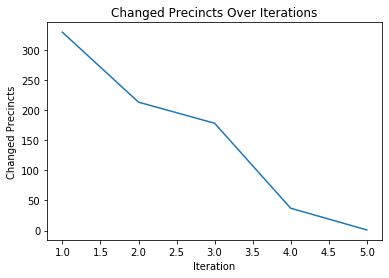

In [15]:
X = list(range(1, len(changed_precincts) + 2))
# The first iteration is the initial guess,
# which can be said to have changed every precinct in the state.
Y = [sum(len(c.precincts) for c in community_stages[0])] \
  + [sum([len(refinement) for refinement in iteration])
     for iteration in changed_precincts]

fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)
ax2.set_title("Changed Precincts Over Iterations")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Changed Precincts")
ax1.xaxis.set_ticks(range(1, len(changed_precincts) + 2))
line, = ax2.plot(X, Y)

Using these communities, we can compare them to the current districts of New Hampshire and get a gerrymandering score.

In [17]:
import json

from shapely.geometry import MultiPolygon, Polygon


# Data is stored as GeoJson.
with open("data/district.json", "r") as f:
    districts = json.load(f)["features"]

district_scores = {}  # Gerrymandering score for each district
for district in districts:
    # Convert coords to Polygon objects.
    json_coords = district["geometry"]["coordinates"]
    if isinstance(coords[0][0][0], float):
        # District is a Polygon.
        coords = [[tuple(point) for point in ring]
                  for ring in json_coords]
        district_shape = Polygon(coords[0], coords[1:])
    else:
        # District is a MultiPolygon.
        coords = [[[tuple(point) for point in ring]
                   for ring in polygon]
                  for polygon in json_coords]
        district_shape = MultiPolygon(
            [Polygon(p[0], p[1:]) for p in coords])
    
    # Find area of intersection for each community.
    areas_intersection = []
    for community in community_stages[-1]:
        areas_intersection.append(
            district_shape.intersection(community.coords).area)
        
    # Find area of district not in community with
    # largest area intersection
    area_outside_community = district_shape.area - max(areas_intersection)
    
    district_scores[district["properties"]["District"]] = \
        area_outside_community
    
for district, score in district_scores.items():
    print(f"{district}\t{score}")
print("State of New Hampshire\t"
     f"{sum(district_scores.values()) / len(districts)}")

New Hampshire 1st	0.2790481287459695
New Hampshire 2nd	0.25355522107044304
State of New Hampshire	0.2663016749082063


These values can be interpreted as percentages, however their limit for the state of New Hamsphire is 0.5. This is because New Hampshire only has 2 districts and therefore only 2 communities, which means that the maximum average amount of space that can be taken up by the community with the largest area in the district is 50%. This would be in the scenario of each district containing the same amount (50%) of each community. When this is applied to a state with 3 districts, the maximum score is 0.666...%. This creates the rule of the maximum gerrymandering score of a state with *n* districts is

\begin{equation*}
\frac{n-1}{n}
\end{equation*}

An interesting side-effect of this rule is that in order for a state to be 100% gerrymandered, it would have to consist of infinity districts.

We have decided not to convert gerrymandering scores into ratios of their own method. Our reasoning is that simply because it is impossible to gerrymander a state with less districts doesn't mean that the gerrymandering that took place there is any more meaningful.

Let's see how these numbers compare to the efficiency gap.

In [ ]:
# Group precincts into districts
